# Classification

## Getting data

In [117]:
import scipy
import numpy
import sklearn
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_validate 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [3]:
dt = pds.read_csv('569a01d3-3538-49da-a03a-63d8d3151235_Data.txt', sep="\t") # load a pandas dataframe from csv in current directory
dt = dt[:-5]
stamps = ['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t', 'CO2 emissions (kg per 2011 PPP $ of GDP)\t', 'Access to electricity (% of population)\t', 'Electricity production from oil, gas and coal sources (% of total)\t', 'GDP per capita growth (annual %)\t', 'Industry (including construction), value added per worker (constant 2010 US$)\t', 'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t', 'International tourism, receipts (% of total exports)\t', 'Exports of goods and services (% of GDP)\t', 'Imports of goods and services (% of GDP)\t', 'Urban population (% of total population)\t', 'Population, total\t', 'Death rate, crude (per 1,000 people)\t', 'Forest area (% of land area)']
dt.columns = stamps
dt.index = dt['Country Name\t']
dt = dt.drop(['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t'], axis=1)
dt = dt.dropna()
dt

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,,,,,,,,,
Albania,0.184922,100.000000,0.000000,1.980930,15410.716379,5431.984311,49.514703,28.213001,47.194844,56.423,2.889104e+06,7.219,28.191972
Algeria,0.275704,99.877052,99.604620,1.699790,27123.281149,19022.535897,0.496957,30.219117,31.926659,70.221,3.892369e+07,4.709,0.818057
Angola,0.189387,32.000000,46.824895,1.219833,57795.491981,1446.776745,2.624433,44.695031,34.637896,62.731,2.694178e+07,9.454,46.507420
Argentina,0.252522,100.000000,64.257069,-3.578581,25174.695235,304184.964709,6.897874,14.405479,14.001315,91.377,4.266950e+07,7.651,10.015311
Australia,0.352370,100.000000,85.093288,1.050180,134038.446027,81470.411093,11.312784,21.039455,21.467035,85.602,2.347569e+07,6.600,16.198664
Austria,0.155262,100.000000,17.721046,-0.122369,99415.945631,26056.410587,8.857949,53.386579,50.116956,57.526,8.546356e+06,9.200,46.862087
Azerbaijan,0.233278,100.000000,94.018926,1.522139,47844.821994,2018.483911,8.333124,43.273557,26.209669,54.422,9.535079e+06,5.800,13.466485
Bahrain,0.534926,100.000000,100.000000,2.706112,50062.321981,10912.131122,5.965235,96.050751,79.513899,88.915,1.336075e+06,2.337,0.765240
Bangladesh,0.154435,62.400000,98.680276,4.856108,3571.749175,869.204249,0.465859,18.989660,25.524420,33.535,1.545202e+08,5.565,10.997926


## Labeling

On choisit la colonne $CO_2$ comme le label qu'on étudiera. On crée $n = 4$ classes de cette colonne grâce à la discrétisation d'après les valeurs croissantes. Ensuite on procedéra en enlevant cette colonne de nos données, tout en gardant la trace de cette colonne pour pouvoir comparer les résultats. 

In [98]:
dt['CO2 emissions (kg per 2011 PPP $ of GDP)\t']
CO_2 = dt['CO2 emissions (kg per 2011 PPP $ of GDP)\t']
CO_2_sorted = CO_2.sort_values()
CO_2_sorted.describe()

count    120.000000
mean       0.243865
std        0.133400
min        0.075353
25%        0.155270
50%        0.212866
75%        0.311126
max        0.724804
Name: CO2 emissions (kg per 2011 PPP $ of GDP)\t, dtype: float64

In [110]:
labels = []
for i in range(120):
    if CO_2[i] < 0.155270:
        labels.append(1)
    elif CO_2[i] < 0.212866:
        labels.append(2)
    elif CO_2[i] < 0.311126:
        labels.append(3)
    else:
        labels.append(4)
labels

[2,
 3,
 2,
 3,
 4,
 1,
 3,
 4,
 1,
 4,
 2,
 3,
 3,
 4,
 2,
 2,
 3,
 4,
 1,
 1,
 4,
 2,
 4,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 4,
 1,
 2,
 3,
 3,
 1,
 4,
 1,
 3,
 1,
 3,
 2,
 1,
 3,
 2,
 2,
 3,
 2,
 1,
 4,
 2,
 4,
 1,
 3,
 2,
 4,
 3,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 3,
 3,
 4,
 3,
 3,
 3,
 1,
 2,
 1,
 3,
 3,
 2,
 1,
 1,
 3,
 1,
 4,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 2,
 4,
 4,
 3,
 4,
 1,
 2,
 3,
 4,
 2,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 2,
 4,
 2,
 4,
 1,
 4,
 4,
 1,
 4]

In [67]:
df = dt
df = df.drop('CO2 emissions (kg per 2011 PPP $ of GDP)\t', axis=1)
df

,Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,,,,,,,,
Albania,100.000000,0.000000,1.980930,15410.716379,5431.984311,49.514703,28.213001,47.194844,56.423,2.889104e+06,7.219,28.191972
Algeria,99.877052,99.604620,1.699790,27123.281149,19022.535897,0.496957,30.219117,31.926659,70.221,3.892369e+07,4.709,0.818057
Angola,32.000000,46.824895,1.219833,57795.491981,1446.776745,2.624433,44.695031,34.637896,62.731,2.694178e+07,9.454,46.507420
Argentina,100.000000,64.257069,-3.578581,25174.695235,304184.964709,6.897874,14.405479,14.001315,91.377,4.266950e+07,7.651,10.015311
Australia,100.000000,85.093288,1.050180,134038.446027,81470.411093,11.312784,21.039455,21.467035,85.602,2.347569e+07,6.600,16.198664
Austria,100.000000,17.721046,-0.122369,99415.945631,26056.410587,8.857949,53.386579,50.116956,57.526,8.546356e+06,9.200,46.862087
Azerbaijan,100.000000,94.018926,1.522139,47844.821994,2018.483911,8.333124,43.273557,26.209669,54.422,9.535079e+06,5.800,13.466485
Bahrain,100.000000,100.000000,2.706112,50062.321981,10912.131122,5.965235,96.050751,79.513899,88.915,1.336075e+06,2.337,0.765240
Bangladesh,62.400000,98.680276,4.856108,3571.749175,869.204249,0.465859,18.989660,25.524420,33.535,1.545202e+08,5.565,10.997926


## Standardization

On remarque que nos données n'ont pas la même échelle ce qui pourrait nous poser problèmes surtout pour la méthode K-NearestNeighbours. Par conséquent, on va standardiser les données grâce à la z-score transformation.

In [69]:
df.describe()

,Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,120.000000,120.000000
mean,87.342678,55.125768,2.172657,44235.910064,21022.984026,10.921623,43.585065,46.772695,63.152792,5.571328e+07,7.878642,30.581768
std,23.282504,32.974741,2.421433,53086.855230,37588.721714,10.947828,29.581383,25.185159,20.349891,1.747168e+08,2.762408,20.179767
min,13.500000,0.000000,-4.731050,605.882819,320.086191,0.359291,9.170091,12.450068,16.219000,3.273860e+05,2.337000,0.006462
25%,87.990330,25.639993,1.025368,10598.725857,2167.185865,3.625724,25.319687,30.475339,49.479000,5.348295e+06,5.982250,12.592530
50%,99.988857,57.102483,2.167883,24305.287768,6373.594599,6.860066,37.335440,40.995620,65.919500,1.113613e+07,7.366500,31.838990
75%,100.000000,86.835535,3.563021,55794.918627,22707.286299,14.306832,51.702944,60.324563,79.373000,4.332011e+07,9.533250,43.709366
max,100.000000,100.000000,7.766030,279960.534903,304184.964709,52.073798,212.607099,180.197084,100.000000,1.364270e+09,15.100000,73.111981


In [73]:
zscore = StandardScaler().fit(df)
dfz = pds.DataFrame(zscore.transform(df), index=df.index, columns=df.columns)
dfz.describe()

,Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
count,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02
mean,5.958197e-16,-3.099373e-17,-2.035409e-17,-6.106227e-17,-3.608225e-17,3.330669e-17,-2.275957e-16,4.255855e-17,7.031412e-17,-7.170190e-18,2.821817e-16,-6.615079e-17
std,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00
min,-3.184893e+00,-1.678767e+00,-2.863038e+00,-8.253072e-01,-5.530835e-01,-9.688332e-01,-1.168278e+00,-1.368526e+00,-2.316011e+00,-3.183329e-01,-2.014503e+00,-1.521499e+00
25%,2.793374e-02,-8.979420e-01,-4.757926e-01,-6.362822e-01,-5.037378e-01,-6.692186e-01,-6.200509e-01,-6.498148e-01,-6.747517e-01,-2.894750e-01,-6.893780e-01,-8.951870e-01
50%,5.454398e-01,6.019770e-02,-1.979998e-03,-3.770084e-01,-3.913624e-01,-3.725476e-01,-2.121547e-01,-2.303459e-01,1.365270e-01,-2.562092e-01,-1.861742e-01,6.256233e-02
75%,5.459204e-01,9.656701e-01,5.765980e-01,2.186506e-01,4.499659e-02,3.105093e-01,2.755759e-01,5.403456e-01,8.004081e-01,-7.123028e-02,6.014847e-01,6.532603e-01
max,5.459204e-01,1.366573e+00,2.319629e+00,4.458976e+00,7.564749e+00,3.774696e+00,5.737755e+00,5.319951e+00,1.818275e+00,7.520989e+00,2.625115e+00,2.116404e+00


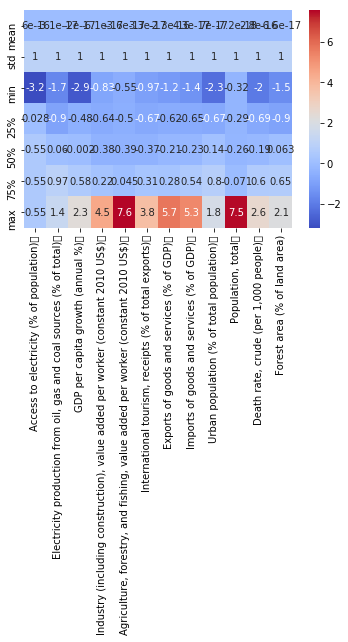

In [74]:
stats = dfz.describe()
stats = stats.drop('count',axis=0)
sns.heatmap(stats,annot=True,cmap='coolwarm')

## K-NN model

In [112]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

scoring = ['accuracy',
           'precision_weighted',
           'recall_weighted',
           'f1_weighted']

knn = KNeighborsClassifier()
scores = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores = pds.DataFrame(scores).mean()

knn = KNeighborsClassifier()
scores_z = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_z = pds.DataFrame(scores_z).mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


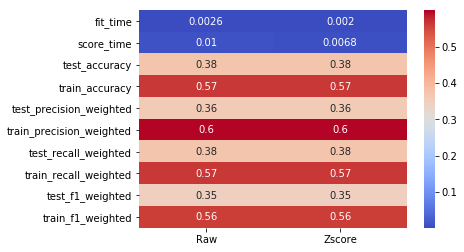

In [113]:
full_scores = pds.DataFrame({"Raw": scores, "Zscore":scores_z})
sns.heatmap(full_scores,annot=True,cmap='coolwarm')

On compare les différentes techniques pour trouver quel modèle nous donne les meuilleurs résultats. 

In [114]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_validate 

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

n_neighbors = [1,3,5]
weights = ["uniform", "distance"]
distances = ["euclidean","manhattan"]

scoring = ['accuracy',
           'precision_weighted',
           'recall_weighted',
           'f1_weighted']

full_scores = {}
for k in n_neighbors:
    for d in distances:
        for w in weights:
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=d)
            scores = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
            scores = pds.DataFrame(scores).mean()
            full_scores[str(k)+"-"+d+"-"+w] = scores

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metri

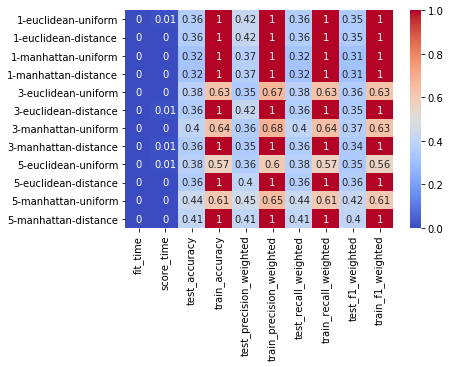

In [116]:
full_scores = pds.DataFrame(full_scores)
sns.heatmap(full_scores.T.round(2),annot=True,cmap='coolwarm')

In [134]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='manhattan')
scores_knn = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_knn = pds.DataFrame(scores_knn).mean()

dt = DecisionTreeClassifier()
scores_dt = cross_validate(dt, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_dt = pds.DataFrame(scores_dt).mean()

svm = SVC(kernel='rbf')
scores_svm = cross_validate(svm, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_svm = pds.DataFrame(scores_svm).mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


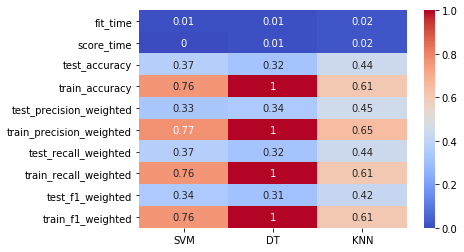

In [135]:
full_scores = pds.DataFrame({"SVM": scores_svm, "DT":scores_dt, "KNN":scores_knn})
sns.heatmap(full_scores.T.round(2).T,annot=True,cmap='coolwarm')